In [1]:
import pandas as pd
import numpy as np
import glob

from prophet.plot import plot_plotly, plot_components_plotly

import plotly.express as px

import locale
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import src.tools as tools

In [3]:
conf = {
    "SEED": 42,
    "fft" : {
        "enabled": True,
        "dt": 1.0,
        "plot_fft": False,
        "convert_period": {
            "sec2day": False,
            "hour2day": False,
            "month2day": False
        },
        "sel_freqs": { 
            "enabled": True,           
            "method": "N-Head",
            "clustering": {
                            "K": 800
            },
            "N-Head": {
                "n": 700,
            },
            "N-Tail": {
                "n": 300,
            },
            "binning": {
                "n": 200,
            },
        },      
    },
    "prophet":{
        "weekly_seasonality": False,
        "daily_seasonality": False,
        "yearly_seasonality": False,
        "interval_width": 0.80,
        "mcmc_samples": 0,
        "uncertainty_samples": 2000,        
        "changepoint_prior_scale": 0.01,        
        "changepoint_range": 0.8,
        "n_changepoints": 5,
        "extra_regressors": {
            "enabled" : False,
            "names": ['TSA', 'PDO']
        },
        "fourier_order": 5,
        "mode": "additive",
        "synthetic_time": True, #For seasonality less than 1 day
    }, 
    "verbose": 1
}
conf

{'SEED': 42,
 'fft': {'enabled': True,
  'dt': 1.0,
  'plot_fft': False,
  'convert_period': {'sec2day': False, 'hour2day': False, 'month2day': False},
  'sel_freqs': {'enabled': True,
   'method': 'N-Head',
   'clustering': {'K': 800},
   'N-Head': {'n': 700},
   'N-Tail': {'n': 300},
   'binning': {'n': 200}}},
 'prophet': {'weekly_seasonality': False,
  'daily_seasonality': False,
  'yearly_seasonality': False,
  'interval_width': 0.8,
  'mcmc_samples': 0,
  'uncertainty_samples': 2000,
  'changepoint_prior_scale': 0.01,
  'changepoint_range': 0.8,
  'n_changepoints': 5,
  'extra_regressors': {'enabled': False, 'names': ['TSA', 'PDO']},
  'fourier_order': 5,
  'mode': 'additive',
  'synthetic_time': True},
 'verbose': 1}

In [4]:
#0 -> swell
#1 -> bimodal
#2 -> multimodal
#3 -> extremo
IDX = 2

In [5]:
dt = 0.78125 #segundos

In [6]:
ddir = './dados/Waverider'
series = ['swell', 'bimodal', 'multimodal', 'extremo']

mcut = 30
dt_cut = [f'2021-06-17 00:{mcut}:00.000000', f'2021-06-20 05:{mcut}:00.000000', f'2021-06-06 03:{mcut}:00.000000', f'2021-04-21 13:{mcut}:00.000000']

In [7]:
arqs = sorted(glob.glob(f"{ddir}/{series[IDX]}/*.raw"))
arqs


['./dados/Waverider/multimodal/2021-06-06T03h00.raw',
 './dados/Waverider/multimodal/2021-06-06T03h30.raw']

In [8]:
df, t_ori = tools.read_files(arqs, dt)
df

,ds,ds_ori,y
0,1950-01-01,2021-06-06 03:00:00.000000,0.18
1,1950-01-02,2021-06-06 03:00:00.781250,-0.07
2,1950-01-03,2021-06-06 03:00:01.562500,-1.01
3,1950-01-04,2021-06-06 03:00:02.343750,-1.04
4,1950-01-05,2021-06-06 03:00:03.125000,-0.47
...,...,...,...
4603,1962-08-09,2021-06-06 03:59:56.093750,-0.44
4604,1962-08-10,2021-06-06 03:59:56.875000,-0.07
4605,1962-08-11,2021-06-06 03:59:57.656250,0.21
4606,1962-08-12,2021-06-06 03:59:58.437500,0.37


In [9]:
fig = px.line(df, x="ds_ori", y="y", title=f"Série de Heave - {series[IDX].capitalize()}", labels={"time_sec": "Tempo (s)", "n1": "n1"})
fig.show()

In [10]:
df_trn, df_tst = tools.split_train_test(df, dt_cut[IDX])
print('Treino:')
display(df_trn)
print('Teste:')
display(df_tst)

Treino:


,ds,y
0,1950-01-01,0.18
1,1950-01-02,-0.07
2,1950-01-03,-1.01
3,1950-01-04,-1.04
4,1950-01-05,-0.47
...,...,...
2300,1956-04-19,0.52
2301,1956-04-20,0.36
2302,1956-04-21,0.08
2303,1956-04-22,-0.50


Teste:


,ds,y
2305,1956-04-24,-0.83
2306,1956-04-25,-0.54
2307,1956-04-26,-0.01
2308,1956-04-27,-0.21
2309,1956-04-28,-0.14
...,...,...
4603,1962-08-09,-0.44
4604,1962-08-10,-0.07
4605,1962-08-11,0.21
4606,1962-08-12,0.37


In [11]:
from src.atm_timeseries.profeta import Profeta

In [12]:
prf = Profeta(conf)

In [13]:
df_trn_corr = df_trn.copy()
#df_trn_corr['y'] = df_trn['y'] * 1.1624
df_trn_corr

,ds,y
0,1950-01-01,0.18
1,1950-01-02,-0.07
2,1950-01-03,-1.01
3,1950-01-04,-1.04
4,1950-01-05,-0.47
...,...,...
2300,1956-04-19,0.52
2301,1956-04-20,0.36
2302,1956-04-21,0.08
2303,1956-04-22,-0.50


[I] Encontrando as sazonalidades
[I] FFT
[I] Máx freqs: 378
[I] N-Head 700
[I] Criando Modelo


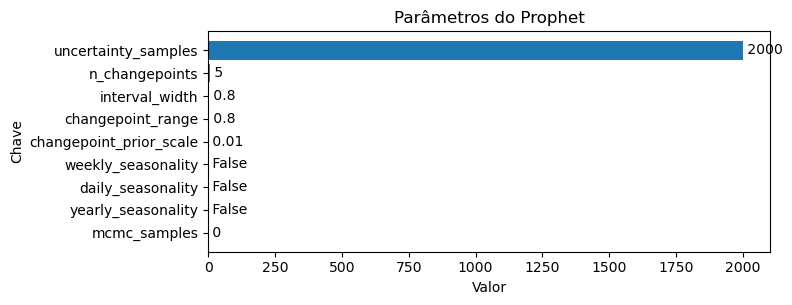

[I] Adicionando Sazonalidades
[I] Ajustando o modelo


17:18:33 - cmdstanpy - INFO - Chain [1] start processing
17:18:40 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
m = prf.fit(df_trn_corr)

In [15]:
future = df[['ds']]

In [16]:
forecast = m.predict(future)

In [17]:
#Voltando pro eixo do tempo original
forecast['ds'] = t_ori
m.history['ds'] = t_ori

In [18]:
fig = plot_plotly(m, forecast)
fig.update_layout(width=1350, height=600) 
fig.show()

In [19]:
import src.waveproc as wave

In [20]:
N = len(df_tst['y'])
print(N)
t = np.arange(N, dtype=float) * dt

2303


In [21]:
sr = df_tst['y'].values
ppt_real, _ = wave.time_domain(t, sr)
ppt_real

,hs,ts,h10,hmax,tz,thmax,hmaxhs
0,1.907455,6.859166,2.387879,3.17,5.400067,8.056956,1.661901


In [22]:
ppf_real, cc_real = wave.freq_domain(t, sr, Fs=1/dt, NFFT=N/8)
ppf_real

,m0,m1,m2,m3,m4,hm0,fp,tp,tm02,tm,v,Qp,L0,k0,BFI
0,0.265519,0.045511,0.009609,0.002499,0.000793,2.066295,0.178397,5.605469,5.256646,5.834135,0.481442,1.592389,49.017197,0.128183,0.263644


In [23]:
pd.concat([ppt_real, ppf_real], axis=1)

,hs,ts,h10,hmax,tz,thmax,hmaxhs,m0,m1,m2,...,hm0,fp,tp,tm02,tm,v,Qp,L0,k0,BFI
0,1.907455,6.859166,2.387879,3.17,5.400067,8.056956,1.661901,0.265519,0.045511,0.009609,...,2.066295,0.178397,5.605469,5.256646,5.834135,0.481442,1.592389,49.017197,0.128183,0.263644


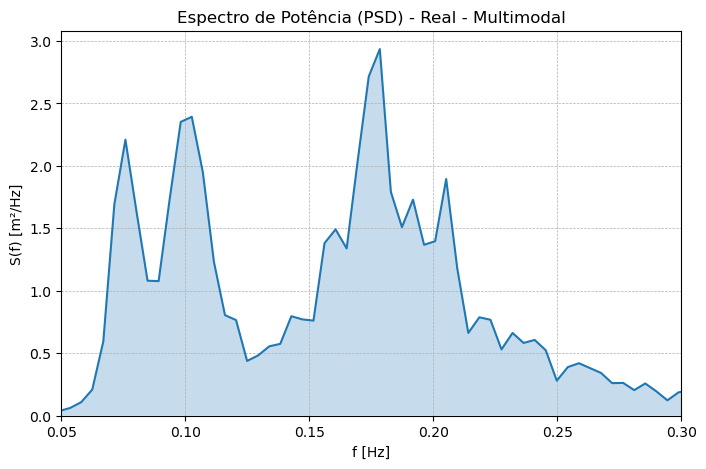

In [24]:
tools.plot_power_spectrum(
    cc_real, 
    cols="c11",
    logx=False,
    logy=False,
    xlim=(0.05, 0.3),
    units="Hz",
    density_label="S(f) [m²/Hz]", 
    title=f"Espectro de Potência (PSD) - Real - {series[IDX].capitalize()}",
    annotate_peaks=False, 
    peak_min_freq=0.05,
    fill=True, 
    fill_alpha=0.25
    )

In [25]:
sp = forecast['yhat'][-N:].values

ppt_prev, _ = wave.time_domain(t, sp)
ppt_prev

,hs,ts,h10,hmax,tz,thmax,hmaxhs
0,1.773554,6.771532,2.243773,2.837973,5.530782,7.358787,1.600162


In [26]:
ppf_prev, cc_prev = wave.freq_domain(t, sp, Fs=1/dt, NFFT=N/8)
ppf_prev

,m0,m1,m2,m3,m4,hm0,fp,tp,tm02,tm,v,Qp,L0,k0,BFI
0,0.250355,0.041141,0.008467,0.002171,0.00068,2.006423,0.093659,10.677083,5.437652,6.085329,0.502401,1.463274,177.840169,0.035331,0.06484


In [27]:
pd.concat([ppt_prev, ppf_prev], axis=1)

,hs,ts,h10,hmax,tz,thmax,hmaxhs,m0,m1,m2,...,hm0,fp,tp,tm02,tm,v,Qp,L0,k0,BFI
0,1.773554,6.771532,2.243773,2.837973,5.530782,7.358787,1.600162,0.250355,0.041141,0.008467,...,2.006423,0.093659,10.677083,5.437652,6.085329,0.502401,1.463274,177.840169,0.035331,0.06484


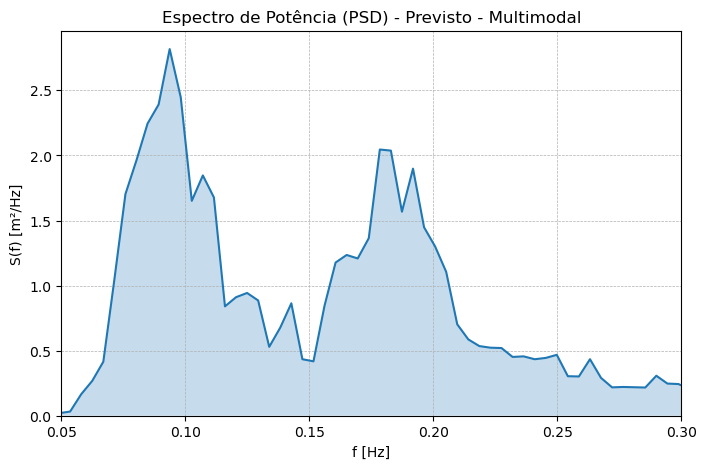

In [28]:
tools.plot_power_spectrum(
    cc_prev, 
    cols="c11",
    logx=False,
    logy=False,
    units="Hz",
    xlim=(0.05, 0.3),
    density_label="S(f) [m²/Hz]", 
    title=f"Espectro de Potência (PSD) - Previsto - {series[IDX].capitalize()}",
    annotate_peaks=False, 
    peak_min_freq=0.05,
    fill=True, 
    fill_alpha=0.25
    )

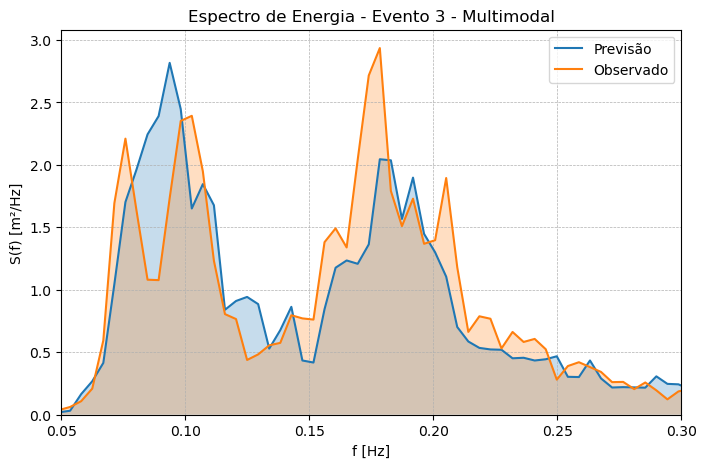

In [29]:
tools.plot_power_spectrum_pair(
    cc_prev, 
    cc_real,
    col1="c11",
    col2="c11",
    logx=False,
    logy=False,
    units="Hz",
    xlim=(0.05, 0.3),
    density_label="S(f) [m²/Hz]", 
    title=f"Espectro de Energia - Evento {IDX+1} - {series[IDX].capitalize()}",    
    peak_min_freq=0.05,
    fill=True, 
    fill_alpha1=0.25,
    fill_alpha2=0.25,
    label1="Previsão",
    label2="Observado"
    )

In [30]:
# Re-enviando a função (o kernel foi reiniciado).

from typing import Optional, Sequence
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _as_row_df(x) -> pd.DataFrame:
    if isinstance(x, pd.Series):
        return x.to_frame().T
    if isinstance(x, pd.DataFrame):
        if x.shape[0] == 1:
            return x
        return x.iloc[[0]]
    raise TypeError("Objeto deve ser pandas Series ou DataFrame.")

def _common_numeric_columns(df_a: pd.DataFrame, df_b: pd.DataFrame) -> Sequence[str]:
    cols_a = {c for c in df_a.columns if np.issubdtype(df_a[c].dtype, np.number)}
    cols_b = {c for c in df_b.columns if np.issubdtype(df_b[c].dtype, np.number)}
    commons = sorted(list(cols_a & cols_b))
    if not commons:
        raise ValueError("Não há colunas numéricas em comum para comparação.")
    return commons

def _bar_compare(one_row_a: pd.DataFrame,
                 one_row_b: pd.DataFrame,
                 commons: Sequence[str],
                 title: str,
                 y_label: Optional[str] = None,
                 label_a: str = "Cenário 1",
                 label_b: str = "Cenário 2",
                 rot: int = 0,
                 logscale: bool = False):
    A = one_row_a[commons].iloc[0].to_numpy(dtype=float)
    B = one_row_b[commons].iloc[0].to_numpy(dtype=float)

    x = np.arange(len(commons))
    width = 0.38

    fig, ax = plt.subplots(figsize=(max(8, len(commons)*0.6), 5))
    ax.bar(x - width/2, A, width, label=label_a)
    ax.bar(x + width/2, B, width, label=label_b)

    ax.set_xticks(x)
    ax.set_xticklabels(commons, rotation=rot, ha="right")
    ax.set_title(title)
    if y_label:
        ax.set_ylabel(y_label)
    if logscale:
        ax.set_yscale("log")
    ax.grid(True, axis="y", linestyle="--", linewidth=0.5)
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_compare_td_fd(
    ppt_prev: pd.DataFrame, ppf_prev: pd.DataFrame,
    ppt_prev2: pd.DataFrame, ppf_prev2: pd.DataFrame,
    label_ref: str = "Cenário 1", label_cmp: str = "Cenário 2",
    td_cols: Optional[Sequence[str]] = None,
    fd_cols: Optional[Sequence[str]] = None,
    td_title: str = "Domínio do tempo — comparação",
    fd_title: str = "Domínio da frequência — comparação",
    td_ylabel: Optional[str] = None,
    fd_ylabel: Optional[str] = None,
    rotate_xticks: int = 0,
):
    td1 = _as_row_df(ppt_prev)
    td2 = _as_row_df(ppt_prev2)
    fd1 = _as_row_df(ppf_prev)
    fd2 = _as_row_df(ppf_prev2)

    if td_cols is None:
        td_cols = _common_numeric_columns(td1, td2)
    else:
        td_cols = [c for c in td_cols if (c in td1.columns and c in td2.columns)]
        if not td_cols:
            raise ValueError("`td_cols` não possui colunas em comum entre os dois DataFrames.")

    if fd_cols is None:
        fd_cols = _common_numeric_columns(fd1, fd2)
    else:
        fd_cols = [c for c in fd_cols if (c in fd1.columns and c in fd2.columns)]
        if not fd_cols:
            raise ValueError("`fd_cols` não possui colunas em comum entre os dois DataFrames.")

    _bar_compare(td1, td2, td_cols, td_title, td_ylabel, label_ref, label_cmp, rotate_xticks)    
    _bar_compare(fd1, fd2, fd_cols, fd_title, fd_ylabel, label_ref, label_cmp, rotate_xticks, logscale=True)


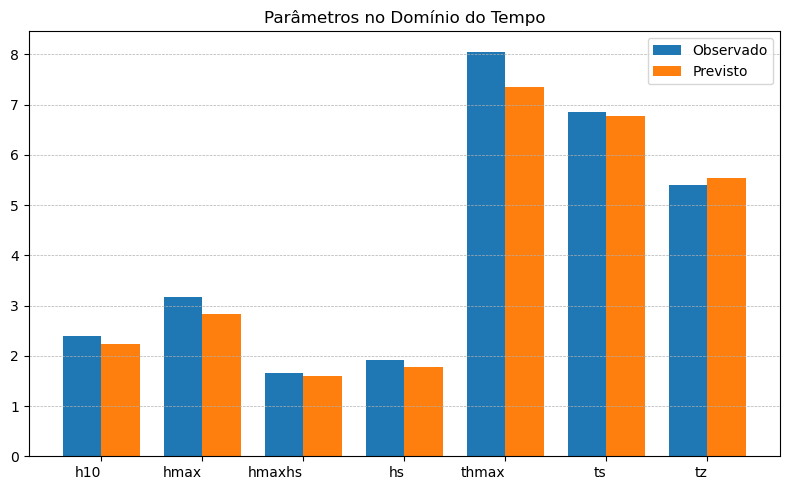

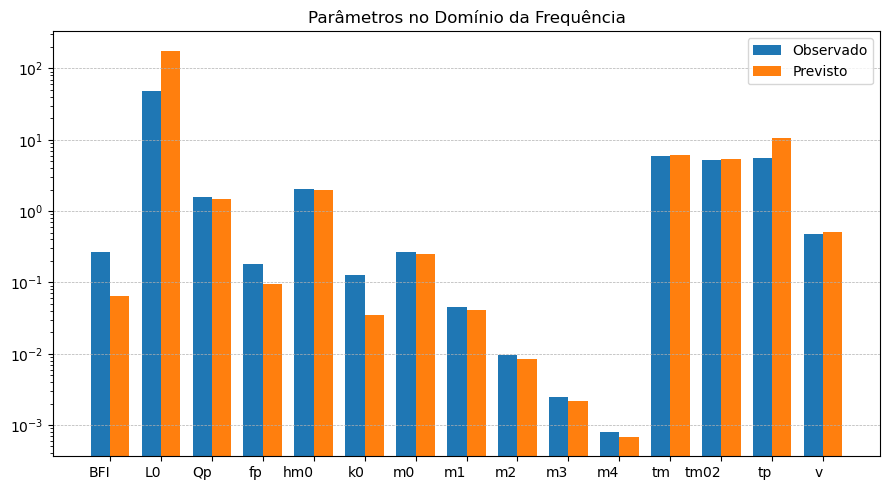

In [31]:

plot_compare_td_fd(ppt_real, ppf_real, ppt_prev, ppf_prev,
                   label_ref="Observado", label_cmp="Previsto",
                   td_title="Parâmetros no Domínio do Tempo",
                   fd_title="Parâmetros no Domínio da Frequência",
                   rotate_xticks=0)


In [32]:

def bar_error_percent(obs: pd.DataFrame, prev: pd.DataFrame, cols, title: str = "Erro percentual — domínio da frequência"):
    a = obs.iloc[0][cols].astype(float)
    b = prev.iloc[0][cols].astype(float)
    # evitar divisão por zero
    eps = 1e-12
    err = 100.0 * (b - a) / np.maximum(np.abs(a), eps)

    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(max(8, len(cols)*0.6), 5))
    ax.bar(np.arange(len(cols)), err.to_numpy())
    ax.set_xticks(range(len(cols)))
    ax.set_xticklabels(cols, rotation=0)
    ax.axhline(0, lw=1)
    ax.set_ylabel("Erro (%)")
    ax.set_title(title)
    ax.grid(True, axis="y", linestyle="--", linewidth=0.5)
    plt.tight_layout(); plt.show()


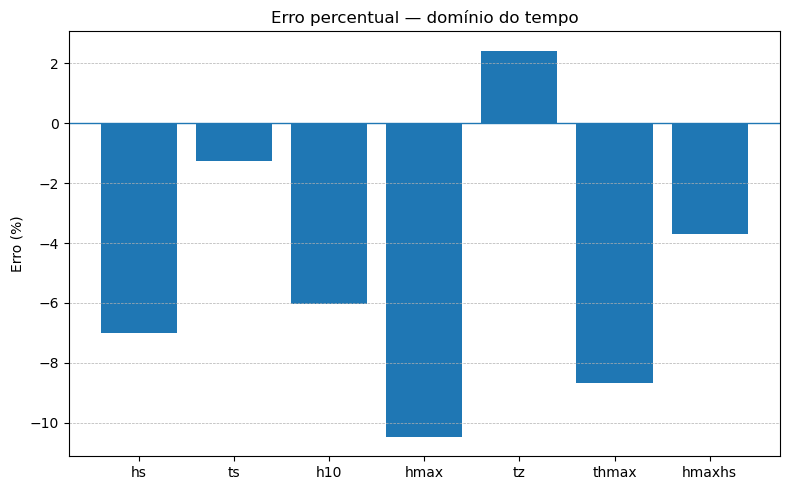

In [33]:
cols = ppt_prev.columns
bar_error_percent(ppt_real,
                  ppt_prev,
                  cols,
                  title="Erro percentual — domínio do tempo")

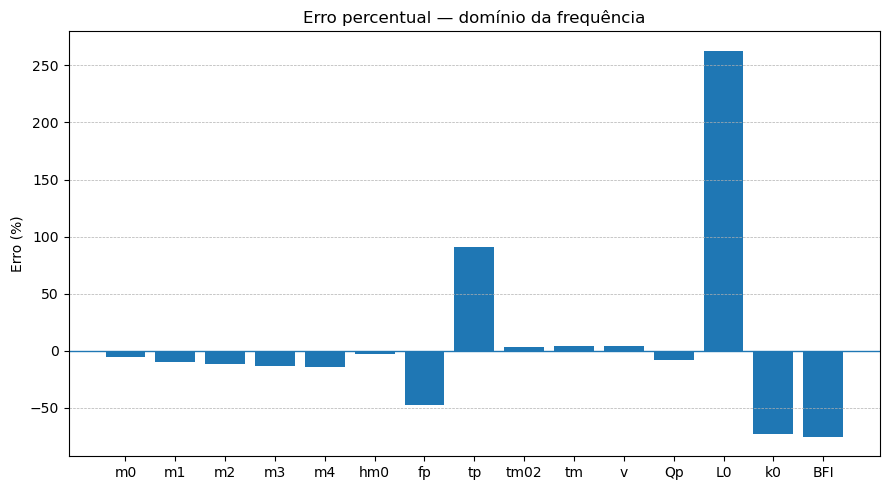

In [34]:

cols = ppf_prev.columns
bar_error_percent(ppf_real,
                  ppf_prev,
                  cols,
                  title="Erro percentual — domínio da frequência")


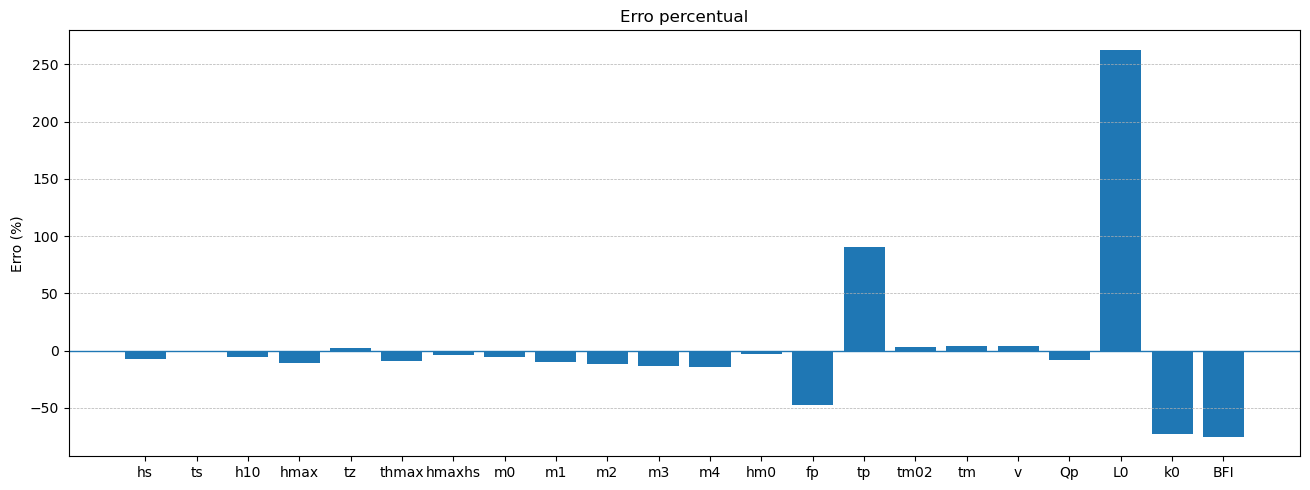

In [35]:
preal = pd.concat([ppt_real, ppf_real], axis=1)
pprev = pd.concat([ppt_prev, ppf_prev], axis=1)

cols = preal.columns
bar_error_percent(preal,
                  pprev,
                  cols,
                  title="Erro percentual")